## Data Preprocessing

In [1]:
import os
from glob import glob
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid


In [2]:
# check if machine has gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on",device)

Running on cpu


In [3]:
# data path that training set is located
path = "../fruits-360"
# this joins the path + folder and each files e.g. '../data/fruits/fruits-360/Training/Apple Braeburn/115_100.jpg'
files_training = glob(os.path.join(path,'Training', '*/*.jpg'))
num_images = len(files_training)
print('Number of images in Training file:', num_images)

Number of images in Training file: 67692


In [4]:
# just to see how many images we have for each label, minimum one and average one, with nice printing style

min_images = 1000
im_cnt = []
class_names = []
print('{:18s}'.format('class'), end='')
print('Count:')
print('-' * 24)
for folder in os.listdir(os.path.join(path, 'Training')):
    folder_num = len(os.listdir(os.path.join(path,'Training',folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
        
num_classes = len(class_names)
print("\nMinumum images per category:", np.min(im_cnt), 'Category:', class_names[im_cnt.index(np.min(im_cnt))])    
print('Average number of Images per Category: {:.0f}'.format(np.array(im_cnt).mean()))
print('Total number of classes: {}'.format(num_classes))

class             Count:
------------------------
Peach Flat           492
Guava                490
Strawberry Wedge     738
Apple Golden 1       480
Carambula            490
Nectarine Flat       480
Corn Husk            462
Pear 2               696
Blueberry            462
Cherry Wax Black     492
Mango                490
Watermelon           475
Tomato Cherry Red    492
Lychee               490
Pear Williams        490
Kohlrabi             471
Apple Red Delicious  490
Cactus fruit         490
Kiwi                 466
Pepino               490
Onion Red            450
Apple Crimson Snow   444
Tomato not Ripened   474
Avocado              427
Walnut               735
Pear Stone           711
Potato Sweet         450
Redcurrant           492
Apple Red Yellow 1   492
Strawberry           492
Nectarine            492
Chestnut             450
Mandarine            490
Pineapple            490
Mango Red            426
Tamarillo            490
Pear Forelle         702
Apple Pink Lady      456


In [5]:
# Just to guess pop_mean and pop_std

tensor_transform = transforms.Compose([transforms.ToTensor()])

training_data = ImageFolder(os.path.join(path, 'Training'), tensor_transform)

data_loader = torch.utils.data.DataLoader(training_data, batch_size=512, shuffle=True)

In [6]:
%time
# this part takes a bit long
pop_mean = [0.6840367,0.5786325,0.5037564]  # normally it was --> []
pop_std = [0.30334985,0.3599262,0.3913685]

# for i, data in tqdm(enumerate(data_loader, 0)):
#     numpy_image = data[0].numpy()
    
#     batch_mean = np.mean(numpy_image, axis=(0,2,3))
#     batch_std = np.std(numpy_image, axis=(0,2,3))
    
#     pop_mean.append(batch_mean)
#     pop_std.append(batch_std)

# pop_mean = np.array(pop_mean).mean(axis=0)
# pop_std = np.array(pop_std).mean(axis=0)

# that is why I am inserting last values 

print(pop_mean)
print(pop_std)

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 11.9 µs
[0.6840367, 0.5786325, 0.5037564]
[0.30334985, 0.3599262, 0.3913685]


In [7]:
np.random.seed(123)
shuffle = np.random.permutation(num_images)

In [8]:
# split validation images

split_val = int(num_images * 0.2)
print('Total number of images:', num_images)
print('Number images in validation set:',len(shuffle[:split_val]))
print('Number images in train set:',len(shuffle[split_val:]))

Total number of images: 67692
Number images in validation set: 13538
Number images in train set: 54154


In [9]:
class FruitTrainDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[split_val:]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

class FruitValidDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[:split_val]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y
    
class FruitTestDataset(Dataset):
    def __init__(self, path, class_names, transform=transforms.ToTensor()):
        self.class_names = class_names
        self.data = np.array(glob(os.path.join(path, '*/*.jpg')))
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'Test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ])
}

train_dataset = FruitTrainDataset(files_training, shuffle, split_val, class_names, data_transforms['train'])
valid_dataset = FruitValidDataset(files_training, shuffle, split_val, class_names, data_transforms['valid'])
test_dataset = FruitTestDataset("../fruits-360/Test", class_names, transform=data_transforms['Test'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [11]:
dataloaders = {'train': train_loader,
              'valid': valid_loader,
              'Test': test_loader}
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'Test': len(test_dataset)
}

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = pop_std * inp + pop_mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

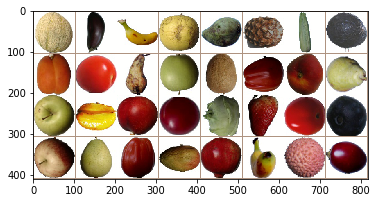

['Cantaloupe 2', 'Eggplant', 'Banana Lady Finger', 'Apple Golden 1', 'Pear Stone', 'Pineapple', 'Corn Husk', 'Avocado ripe', 'Apricot', 'Tomato Cherry Red', 'Pear Abate', 'Apple Granny Smith', 'Kiwi', 'Tomato Heart', 'Nectarine Flat', 'Pear Williams', 'Apple Golden 3', 'Carambula', 'Nectarine', 'Cherry Wax Red', 'Kohlrabi', 'Strawberry', 'Tomato 4', 'Blueberry', 'Apple Red 3', 'Pear', 'Tomato Heart', 'Papaya', 'Pomegranate', 'Banana Lady Finger', 'Lychee', 'Tamarillo']


In [13]:
inputs, classes = next(iter(train_loader))
out = make_grid(inputs)

cats = ['' for x in range(len(classes))]
for i in range(len(classes)):
    cats[i] = class_names[classes[i].item()]
    
imshow(out)
print(cats)

In [14]:
# just to check if shape of train and test sets match
for i,j in zip(train_loader,test_loader):
    print(i[0].shape,j[0].shape)
    break

torch.Size([32, 3, 100, 100]) torch.Size([32, 3, 100, 100])


## Network

In [15]:
class InceptionM(nn.Module):
    def __init__(self, in_channels):
        super(InceptionM, self).__init__()
        
        self.branch_1_1 = nn.Conv2d(in_channels, 16, kernel_size = 1)
        
        self.branch_2_1 = nn.Conv2d(in_channels, 16, kernel_size = 1)
        self.branch_2_2 = nn.Conv2d(16, 24, kernel_size = 5, padding = 2)
        
        self.branch_3_1 = nn.Conv2d(in_channels, 16, kernel_size = 1)
        self.branch_3_2 = nn.Conv2d(16, 24, kernel_size = 3, padding = 1)
        self.branch_3_3 = nn.Conv2d(24, 24, kernel_size = 3, padding = 1)
        
        self.branch_4_1 = nn.Conv2d(in_channels, 24, kernel_size = 1)
        
    def forward(self, x):
        
        branch1 = self.branch_1_1(x)
        branch2 = self.branch_2_2(self.branch_2_1(x))
        branch3 = self.branch_3_3(self.branch_3_2(self.branch_3_1(x)))
        branch4 = F.avg_pool2d(x, kernel_size = 3, stride = 1, padding = 1)
        branch4 = self.branch_4_1(branch4)
        
        output = [branch1, branch2, branch3, branch4]
        
        return torch.cat(output, 1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # initialize the parent class methods
        
        self.conv1 = nn.Conv2d(3, 10, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(10, 24, kernel_size = 5, stride = 5)
        self.conv3 = nn.Conv2d(24, 128, kernel_size = 5, stride = 1)
        
        self.pool1 = nn.MaxPool2d(4, stride = 1)
        self.pool2 = nn.MaxPool2d(4, stride = 1)
        #self.pool3 = nn.MaxPool2d(4, stride = 1)
        
        #self.pool2 = nn.AvgPool2d(kernel_size = 5, stride = 1, padding = 0)
        self.pool3 = nn.AvgPool2d(kernel_size = 5, stride = 5, padding = 0)
        
        #self.incept1 = InceptionM(in_channels = 10)
        #self.incept2 = InceptionM(in_channels = 24)
        #self.incept3 = InceptionM(in_channels = 128)
        
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 131)
        
    def forward(self, x):   
        in_size = x.size(0)
        
        x = F.relu(self.pool1(self.conv1(x)))
        #x = self.incept1(x)
        
        x = self.conv2(x)
        x = F.relu(self.pool2(x))
        #x = self.incept2(x)
        
        x = self.conv3(x)
        x = self.pool3(x)
        x = F.relu(x)
        #x = self.incept3(x)
        
        x = x.view(in_size, -1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(88, 24, kernel_size=(5, 5), stride=(5, 5))
  (conv3): Conv2d(88, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  (pool3): AvgPool2d(kernel_size=5, stride=5, padding=0)
  (incept1): InceptionM(
    (branch_1_1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch_2_1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch_2_2): Conv2d(16, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (branch_3_1): Conv2d(10, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch_3_2): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch_3_3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch_4_1): Conv2d(10, 24, kernel_size=(1, 1), stride=(1, 1))
  )
  (incept2): InceptionM(
    (

In [16]:
# move network to GPU
net = Net().to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.7)

In [18]:
# let's train the network
def train(net):
    for epoch in tqdm(range(10)):
        print("epoch {}".format(epoch))
        running_loss = 0.0
        correct = 0
        total = 0

        for i,data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            
            # in sample accuracy calculation
            _, predicted = torch.max(outputs, 1) 
            a = predicted == labels
            correct += np.count_nonzero(a.cpu())
            total += len(a)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            
            if i % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f, in sample accuracy: %.3f' %(epoch, i + 1, running_loss / 100, correct/total))
                running_loss = 0.0
                correct = 0
                total = 0
                
    print('Finished Training')
    
train(net)

epoch 0
[0,   100] loss: 4.881, in sample accuracy: 0.009


KeyboardInterrupt: 

In [33]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(test_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))

test(net)


Accuracy of the network on the test images: 84 %


In [34]:
# label wise accuracy
class_correct = list(0. for i in range(131))
class_total = list(0. for i in range(131))
with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(131):
    print('Accuracy of %5s : %2d %%' % (
    class_names[i], 100 * class_correct[i] / class_total[i]))

KeyboardInterrupt: 

* In sample accuracy can be added to train function

* Plots will be done (loss + in_sample_accuracy etc) for model analysis

* This network will be extended (maybe adding new layer or changing other parameters)
    * This matter tried and saved as a second model, but results didn't change too much and training set took more time, so we can exclude this option. As a last trial, batch size is changed from 64 to 32 and in this case network worked better and total accuracy increased to %86

* Other architecture (especially CNN and its variants) will be tested

## Model Analysis Part

In [35]:
# let's train the network
def train(net):
    with open("model.log", "a") as f:
        for epoch in tqdm(range(10)):
            print("epoch {}".format(epoch))
            running_loss = 0.0
            correct = 0
            total = 0

            val_loss = 0.0
            val_cor = 0
            val_tot = 0

            for i,data in enumerate(train_loader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs.view(-1,3*100*100))

                # in sample accuracy calculation
                _, predicted = torch.max(outputs, 1) 
                a = predicted == labels
                correct += np.count_nonzero(a.cpu())
                total += len(a)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()

                if i % 5 == 4 :    # print every 100 mini-batches
                    val_data = next(iter(train_loader))
                    val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)

                    val_outputs = net(val_inputs.view(-1,3*100*100))

                    # in sample accuracy calculation
                    _, val_predicted = torch.max(val_outputs, 1) 
                    b = val_predicted == val_labels
                    val_cor += np.count_nonzero(a.cpu())
                    val_tot += len(b)
                    val_loss = criterion(val_outputs, val_labels)
                    val_loss += val_loss.item()

                    print('[%d, %5d] loss: %.3f, in sample accuracy: %.3f, val_loss: %.3f, val accuracy : %.3f' %(epoch, i + 1, running_loss / 5, correct/total,
                                                                            val_loss / 5, val_cor/val_tot))
                    
                    f.write(f"{float(correct/total)},{float(running_loss / 5)},{float(val_cor/val_tot)},{float(val_loss / 5)}\n")
                    
                    running_loss = 0.0
                    correct = 0
                    total = 0

                    val_loss = 0.0
                    val_cor = 0
                    val_tot = 0

        print('Finished Training')
    
train(net)

epoch 0



UnboundLocalError: local variable 'correct' referenced before assignment

In [ ]:
model_data = pd.read_csv("model.log",names = ["accuracy","loss","validation_accuracy","validation_loss"])
model_data.head()

In [ ]:
max(model_data["accuracy"]), max(model_data["validation_accuracy"])

In [ ]:
plt.style.use("ggplot")
plt.plot(model_data["loss"])
plt.plot(model_data["validation_loss"])

In [ ]:
plt.plot(model_data["accuracy"])
plt.plot(model_data["validation_accuracy"])